In [2]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import einops
import math

In [3]:
names = list((open('data/names/names.txt', 'r').read().splitlines()))

chars = sorted(set(''.join(names)))
char_to_idx = {s: i for i, s in enumerate(['.'] + chars)}
index_to_char = {i: s for s, i in char_to_idx.items()}

names[:5], chars[:5]

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], ['a', 'b', 'c', 'd', 'e'])

In [4]:
char_to_idx['a'], char_to_idx['b'], char_to_idx['c'], char_to_idx['d'], char_to_idx['e']

(1, 2, 3, 4, 5)

In [5]:
index_to_char[0], index_to_char[1], index_to_char[2], index_to_char[3], index_to_char[4]

('.', 'a', 'b', 'c', 'd')

In [6]:
xs, ys = [], []
context_size = 3
for name in names:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        context = context[1:] + [idx]

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [7]:
train_size = int(0.8 * len(xs))
dev_size = int(0.1 * len(xs))
test_size = len(xs) - train_size - dev_size
train_size, dev_size, test_size, train_size + dev_size + test_size

idxs_in_random_order = torch.randperm(len(xs))
train_idxs = idxs_in_random_order[:train_size]
dev_idxs = idxs_in_random_order[train_size:train_size + dev_size]
test_idxs = idxs_in_random_order[train_size + dev_size:]

train_xs, train_ys = xs[train_idxs], ys[train_idxs]
dev_xs, dev_ys = xs[dev_idxs], ys[dev_idxs]
test_xs, test_ys = xs[test_idxs], ys[test_idxs]

train_xs.shape, train_ys.shape, dev_xs.shape, dev_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22814, 3]),
 torch.Size([22814]),
 torch.Size([22816, 3]),
 torch.Size([22816]))

In [8]:
embedding_size = 10
hidden_size = 200
vocab_size = 27
g = torch.Generator().manual_seed(2147483647)

embedding = torch.randn((vocab_size, embedding_size),          generator=g)
# W1 = torch.randn((context_size * embedding_size, hidden_size), generator=g)
# b1 = torch.randn((hidden_size,),                               generator=g)
# To fix tanh from getting extreme values, and vanishing gradients, we decrease
# the scale of the weights and biases of the first layer, below there are plots explaining
# The value (5/3) / math.sqrt(context_size * embedding_size) is the kaiming initialization 
W1 = torch.randn((context_size * embedding_size, hidden_size), generator=g) * (5/3) / math.sqrt(context_size * embedding_size)
# Since now we're using batch normalization, the biases are not used anymore
# b1 = torch.randn((hidden_size,),                               generator=g) * 0.01

# To fix initial loss, we squash the weights and biases of the output layer
# to near zero/zero, to make sure the logits are around zero and more or less uniform
# making sure the initial loss is near -log(1/27) ~= 3.2
# remember the loss is -log(p) and p = 1/27 would be the uniform distribution probability
# for all 27 characters
# W2 = torch.randn((hidden_size, vocab_size),                    generator=g)
# b2 = torch.randn((vocab_size,),                                generator=g)
W2 = torch.randn((hidden_size, vocab_size),                    generator=g) * 0.01
b2 = torch.randn((vocab_size,),                                generator=g) * 0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))

bnmean_run = torch.zeros((1, hidden_size))
bnstd_run = torch.ones((1, hidden_size))

params = [
    embedding, 
    W1, 
    # b1, 
    W2, 
    b2, 
    bngain, 
    bnbias
]
for p in params:
    p.requires_grad = True
print(f"{embedding.size()=}")
print(f"{W1.size()=}") 
#   ,{b1.size()=}")
print(f"{W2.size()=}, {b2.size()=}")
print(f"parameters count = {sum(p.numel() for p in params)}")

embedding.size()=torch.Size([27, 10])
W1.size()=torch.Size([30, 200])
W2.size()=torch.Size([200, 27]), b2.size()=torch.Size([27])
parameters count = 12097


In [9]:
def forward_pass(batch, inference=False):
    global bnmean_run, bnstd_run
    embeds = einops.rearrange(
        embedding[batch], "batch context embed -> batch (context embed)"
    )
    h_preact = einops.einsum(
        embeds, W1, "batch c_embed, c_embed hidden -> batch hidden") # + b1
    # Problem: We want pre-activations to not take extreme values (so gradients won't flow because
    # of the derivative of non-linearities such as tanh are zeroed), but also not to be too small
    # (such that non-linearities output are too close to zero)
    # Solution: So pre-activations should be normally distributed
    # To achieve this let's normalize the pre-activations, shifting them by the mean and
    # dividing by their standard deviation
    bnmean_i = h_preact.mean(dim=0, keepdim=True) if not inference else bnmean_run
    bnstd_i = h_preact.std(dim=0, keepdim=True) if not inference else bnstd_run
    h_preact = (h_preact - bnmean_i) / (bnstd_i + 1e-5)
    # Issue: By forcing the pre-activations to be normally distributed, we're not letting the
    # network to learn values that are not normally distributed, this should only be true in
    # initialization
    # Solution: We can introduce a scaling and shifting parameters to the network
    # such that it can learn values that let the distribution be what we need
    h_preact = h_preact * bngain + bnbias

    # Another issue that arises is that since we're now coupling the pre-activations with the
    # batch input, when we want to perform inference, we don't have a batch to calculate the
    # mean and std, so in order to fix this, we'll calculate the mean and std of the training run
    # and use it for inference
    with torch.no_grad():
        if not inference:
            bnmean_run = bnmean_run * 0.999 + bnmean_i * 0.001
            bnstd_run = bnstd_run * 0.999 + bnstd_i * 0.001
    # This process is called batch normalization, however coupling the activations with the batch
    # input is not a good idea, since you're creating a dependency of the training run on the batch
    # values. There are other options like group normalization, layer normalization, which are more
    # robust and commonly used
    h = torch.tanh(h_preact)
    logits = einops.einsum(
        h, W2, "batch hidden, hidden vocab -> batch vocab"
    ) + b2
    return logits, (embeds, h_preact, h)

In [11]:
batch_size = 32
epochs = 200000
losses = []
for i in range(epochs):
    idxs = torch.randint(0, train_xs.shape[0], (batch_size, ), generator=g)
    logits, (embeds, h_preact, h) = forward_pass(train_xs[idxs])
    loss = F.cross_entropy(logits, train_ys[idxs])

    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i=}, {loss.item()=}")

    losses.append(loss.log10().item())


i=0, loss.item()=3.2968807220458984
i=10000, loss.item()=2.3967316150665283
i=20000, loss.item()=2.7331554889678955
i=30000, loss.item()=2.1923880577087402
i=40000, loss.item()=2.1207504272460938
i=50000, loss.item()=1.8946934938430786
i=60000, loss.item()=2.2031848430633545
i=70000, loss.item()=2.4535269737243652
i=80000, loss.item()=2.1582939624786377
i=90000, loss.item()=2.2906980514526367
i=100000, loss.item()=1.928140640258789
i=110000, loss.item()=2.0683321952819824
i=120000, loss.item()=1.9248006343841553
i=130000, loss.item()=1.8973199129104614
i=140000, loss.item()=2.464226007461548
i=150000, loss.item()=1.8834363222122192
i=160000, loss.item()=1.9906857013702393
i=170000, loss.item()=1.8316899538040161
i=180000, loss.item()=2.185960292816162
i=190000, loss.item()=1.7225074768066406


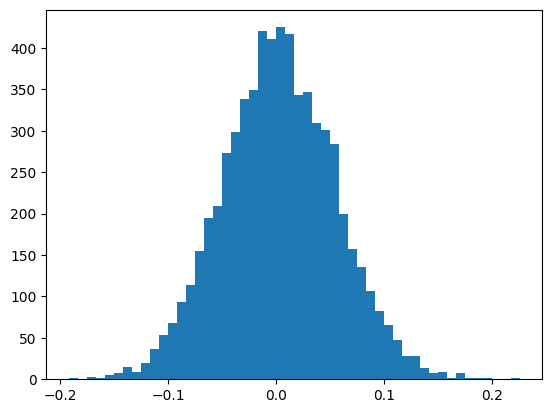

In [ ]:
# tanh is a sigmoid function that squashes the values between -1 and 1
# We can see from the histogram that the values are concentraded on the extremes
# This means that the values pre-activation are high
# If the values here are not high is because the run that generated the pre-activations
# is already the one with fixed weights initialization and/or batch normalization
plt.hist(h.view(-1).tolist(), 50);

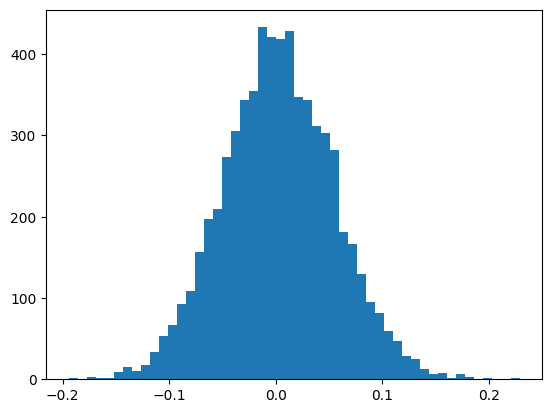

In [104]:
# The histogram of the pre-activation values is spread out, with high values
plt.hist(h_preact.view(-1).tolist(), 50);

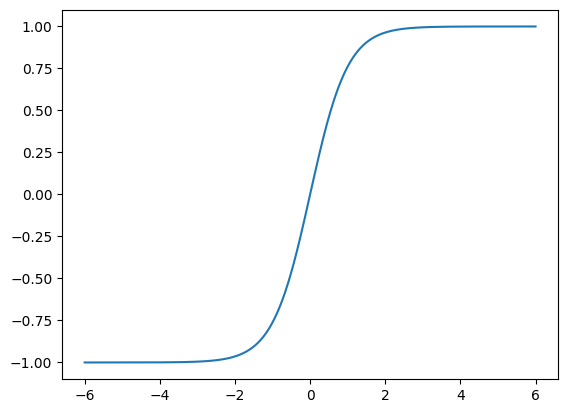

In [96]:
# This is awful for the gradient of tanh, as it goes to zero as the values get further from zero
# We're vanishing the gradients
x = torch.linspace(-6, 6, 1000)
y = torch.tanh(x)
plt.plot(x.tolist(), y.tolist());


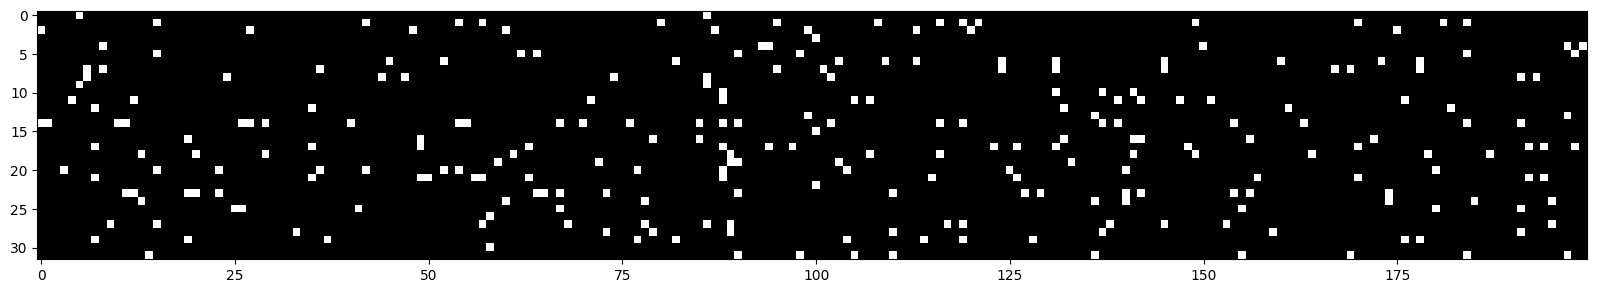

In [144]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > .99, cmap="gray", interpolation="nearest");

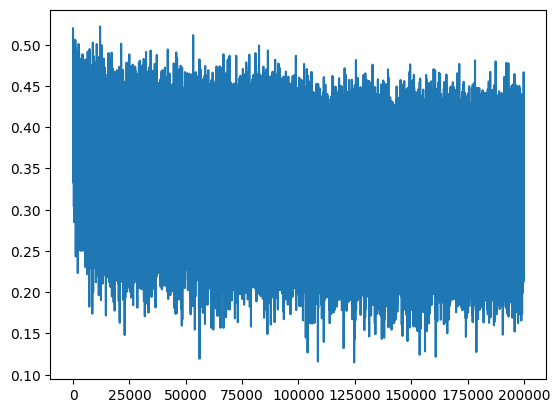

In [181]:
plt.plot([i for i in range(epochs)], losses)

In [12]:
@torch.no_grad()  # avoids gradient bookeeping for backward pass
def split_loss(split_name: str):
    x, y = {
        "train": (train_xs, train_ys),
        "dev": (dev_xs, dev_ys),
        "test": (test_xs, test_ys)
    }[split_name]
    logits, _ = forward_pass(x)
    loss = F.cross_entropy(logits, y).item()
    print(f"{split_name=}, {loss=}")

split_loss("train")
split_loss("dev")

split_name='train', loss=2.0668892860412598
split_name='dev', loss=2.116572856903076


In [13]:
for _ in range(20):
    name = ""
    context = [0, 0, 0]
    while True:
        logits, _ = forward_pass(torch.tensor(context).unsqueeze(0), inference=True)
        probs = logits.softmax(dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        next_char = index_to_char[idx]
        name += next_char
        if next_char == ".":
            break
    print(name)


joyal.
der.
keyler.
alizachvann.
fadalexyn.
kheiki.
jaqu.
aive.
poutu.
bas.
xar.
sri.
koella.
josi.
itz.
caseba.
xari.
adel.
bec.
yurla.


Let's summarize the code and rewrite the code in a pytorch fashion

In [10]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.b = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = einops.einsum(x, self.W, "batch in, in out -> batch out")
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


In [16]:
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self.training = True
    
    def __call__(self, x):
        print(f"x.shape: {x.shape}")
        batch_mean = x.mean(dim=0, keepdim=True) if self.training else self.running_mean
        print(f"batch_mean.shape: {batch_mean.shape}")
        batch_var = x.var(dim=0, keepdim=True) if self.training else self.running_var
        print(f"batch_var.shape: {batch_var.shape}")
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
        x_norm = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        print(f"x_norm.shape: {x_norm.shape}")
        self.out = self.gamma * x_norm + self.beta
        print(f"self.out.shape: {self.out.shape}")
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [12]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.embeddings = torch.randn((num_embeddings, embedding_dim), generator=g)# / num_embeddings**0.5
    
    def __call__(self, x):
        embeds = self.embeddings[x]
        return einops.rearrange(embeds, "batch context embed -> batch (context embed)")
    
    def parameters(self):
        return [self.embeddings]
    

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [17]:
# class NGram:
#     def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
#         self.embedding = Embedding(vocab_size, embedding_dim)
#         self.mlp = [
#             Linear(context_size * embedding_dim, hidden_size, bias=False), Tanh(),
#             Linear(hidden_size, hidden_size, bias=True), Tanh(),
#             Linear(hidden_size, hidden_size, bias=True), Tanh(),
#             Linear(hidden_size, hidden_size, bias=True), Tanh(),
#             Linear(hidden_size, hidden_size, bias=True), Tanh(),
#             Linear(hidden_size, vocab_size, bias=True),
#         ]
#         self.__post_init__()
    
#     def __post_init__(self):
#         self.layers[-1].W *= 0.01  # output layer smoothed to avoid extreme values
#         for l in self.layers[:-1]:
#             if isinstance(l, Linear):
#                 l.W *= 5/3  # kaiming initialization depends on the nonlinearity used
    
#     def __call__(self, x):
#         out = self.embedding(x)
#         for l in self.mlp:
#             out = l(out)
#         return out
    
#     @property
#     def layers(self):
#         return [
#             self.embedding,
#             *self.mlp,
#         ]
    
#     def parameters(self):
#         return [p for l in self.layers for p in l.parameters()]


* Comment the Ngram class above and uncomment the one below to use batch normalization
* The purpose of bn is to make the neural network less susceptible to the distribution and scale of input and weights initialization

In [18]:
class NGram:  # with batch normalization
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.mlp = [
            Linear(context_size * embedding_dim, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            # Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            # Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            # Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            # Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, vocab_size, bias=False), BatchNorm1d(vocab_size)
        ]
        self.__post_init__()
    
    def __post_init__(self):
        self.layers[-1].gamma *= 0.1
        for l in self.layers[:-1]:
            if isinstance(l, Linear):
                l.W *= 5/3
    
    def __call__(self, x):
        out = self.embedding(x)
        for l in self.mlp:
            out = l(out)
        return out
    
    @property
    def layers(self):
        return [
            self.embedding,
            *self.mlp,
        ]
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [19]:
vocab_size = 27
embedding_dim = 10
context_size = 3
hidden_size = 100
model = NGram(vocab_size, embedding_dim, context_size, hidden_size)

for p in model.parameters():
    p.requires_grad = True


In [20]:
epochs = 200000
batch_size = 32
losses = []
update_to_data_ratio = []
for i in range(epochs):
    idxs = torch.randint(0, train_xs.shape[0], (batch_size, ), generator=g)
    logits = model(train_xs[idxs])
    loss = F.cross_entropy(logits, train_ys[idxs])

    for l in model.layers[1:]:
        l.out.retain_grad()
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i=}/{epochs}, {loss.item()=}")
    
    with torch.no_grad():
        update_to_data_ratio.append([
            (lr * p.grad.std() / p.data.std()).log10().item() 
            for p in model.parameters()
        ])
    break
    if i > 1000:    
        break

torch.Size([32, 100])
torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 27])
torch.Size([1, 27])
torch.Size([1, 27])
torch.Size([32, 27])
torch.Size([32, 27])
i=0/200000, loss.item()=3.310468912124634


/Users/guilhermemarques/miniconda3/envs/mech_interp/lib/python3.9/site-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: in
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


* Below we are checking the distribution of the nonlinearities activations
* They should be roughly gaussian:
    * To avoid vanishing gradients
    * To avoid dead activations
* So we check the mean and std deviation of the activations
* We also check percentage of value from the activations that are larger than 0.97 in absolute value. Remember the plot of tanh, -1 or 1 are where the gradients are zeroed

Layer 2 outs: mean=-0.001445, std=7.409793e-01, saturation=18.12%
Layer 4 outs: mean=+0.000050, std=7.126498e-01, saturation=9.75%
Layer 6 outs: mean=+0.006378, std=7.086968e-01, saturation=11.06%
Layer 8 outs: mean=+0.011470, std=7.212625e-01, saturation=10.66%
Layer 10 outs: mean=-0.039883, std=7.103604e-01, saturation=9.50%


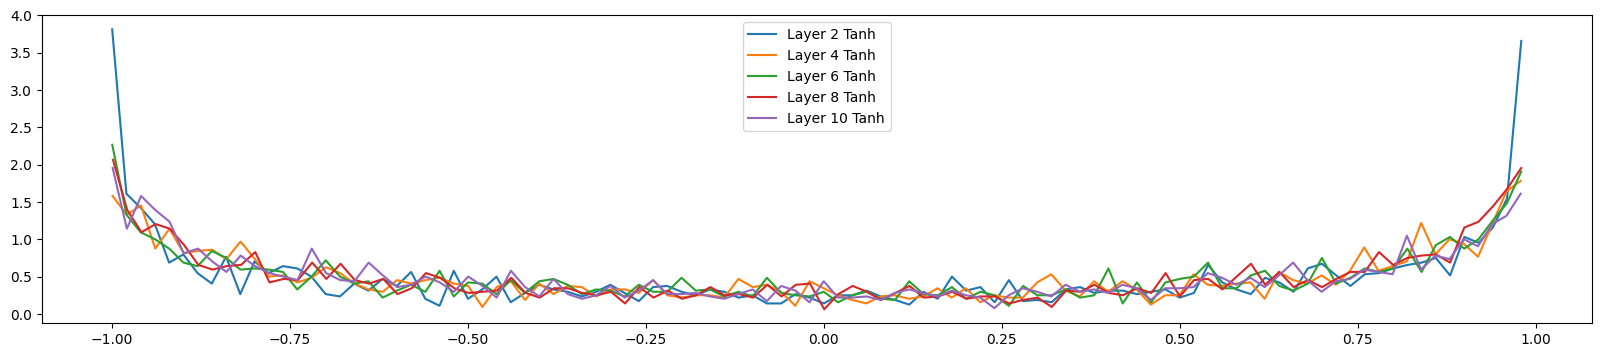

In [267]:
plt.figure(figsize=(20, 4))
legends = []
for i, l in enumerate(model.layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out
        mean, std = t.mean().item(), t.std().item()
        saturation = ((t.abs() > .97).float().mean() * 100).item()
        print(f"Layer {i} outs: mean={mean:+f}, std={std:e}, saturation={saturation:.2f}%")
        ty, tx = torch.histogram(t, density=True)
        plt.plot(tx[:-1].detach(), ty.detach())
        legends.append(f"Layer {i} {l.__class__.__name__}")
plt.legend(legends);

* Belo we are checking the gradients distribution to make sure they also are roughly normally distributed

Layer 2 grads: mean=-0.000088, std=2.855195e-03
Layer 4 grads: mean=-0.000026, std=2.827212e-03
Layer 6 grads: mean=-0.000085, std=2.730663e-03
Layer 8 grads: mean=-0.000151, std=2.495435e-03
Layer 10 grads: mean=+0.000019, std=2.089351e-03


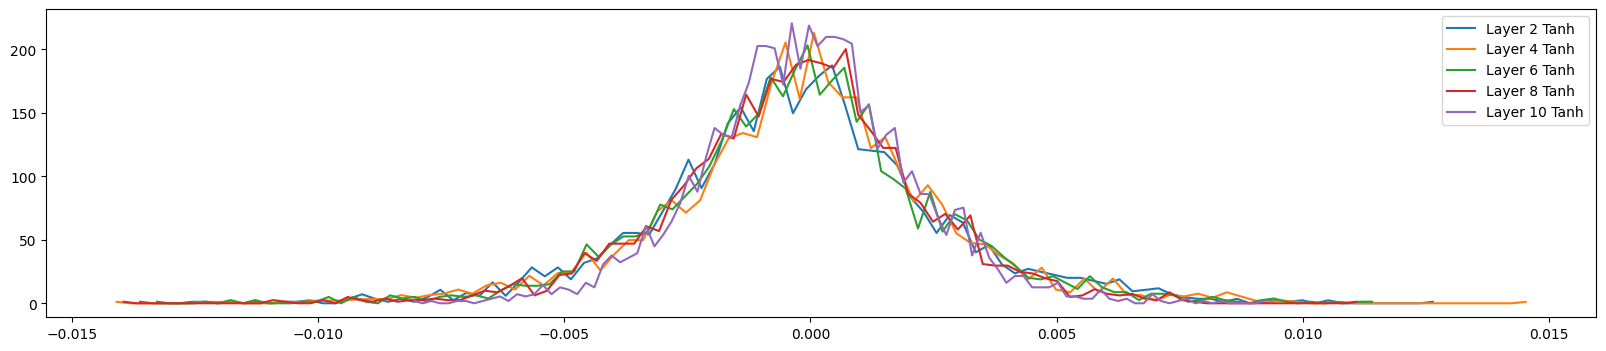

In [268]:
plt.figure(figsize=(20, 4))
legends = []
for i, l in enumerate(model.layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out.grad
        mean, std = t.mean().item(), t.std().item()
        print(f"Layer {i} grads: mean={mean:+f}, std={std:e}")
        ty, tx = torch.histogram(t, density=True)
        plt.plot(tx[:-1].detach(), ty.detach())
        legends.append(f"Layer {i} {l.__class__.__name__}")
plt.legend(legends);

* Finally we check the distribution of the weights
* Additionaly we also check the ratio between the gradients and the weights
* However this static ratio does not tell much besides, we need to understand what is the ration of updates to data


Layer 0 W.shape=(27, 10), W.mean=+0.016580, W.std=9.713384e-01, W.grad:W.data ratio 1.268611e-02
Layer 1 W.shape=(30, 100), W.mean=-0.004624, W.std=3.063731e-01, W.grad:W.data ratio 3.237087e-02
Layer 2 W.shape=(100, 100), W.mean=-0.001203, W.std=1.682263e-01, W.grad:W.data ratio 4.556758e-02
Layer 4 W.shape=(100, 100), W.mean=-0.000721, W.std=1.681907e-01, W.grad:W.data ratio 4.419457e-02
Layer 6 W.shape=(100, 100), W.mean=-0.001555, W.std=1.694297e-01, W.grad:W.data ratio 4.013719e-02
Layer 8 W.shape=(100, 100), W.mean=+0.001045, W.std=1.685440e-01, W.grad:W.data ratio 3.384568e-02
Layer 10 W.shape=(100, 27), W.mean=-0.000024, W.std=6.879388e-02, W.grad:W.data ratio 3.526371e-01


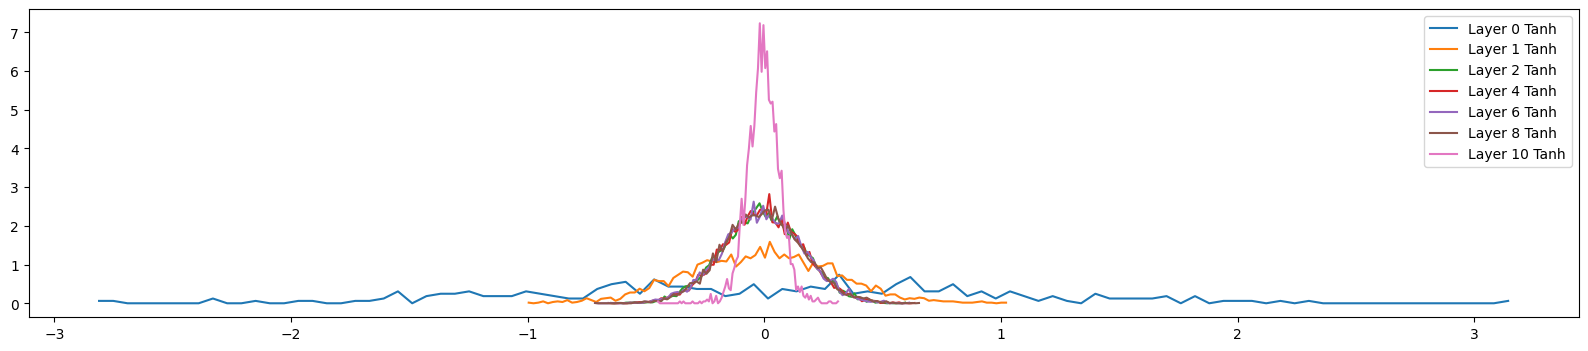

In [271]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 2:
        w = p
        grad = w.grad
        mean, std = w.mean().item(), w.std().item()
        print(f"Layer {i} W.shape={tuple(w.shape)}, W.mean={mean:+f}, W.std={std:e}, W.grad:W.data ratio {grad.std()/w.std():e}")
        ty, tx = torch.histogram(w, density=True)
        plt.plot(tx[:-1].detach(), ty.detach())
        legends.append(f"Layer {i} {l.__class__.__name__}")
plt.legend(legends);

* Below we are plotting the ratio between the updates and the data
* With this ration we can understand how much the updates affects the weights after each epoch
* Allowing us to understand if the updates are too large or too small
* Therefore we can adjust the learning rate accordingly, but also initialization of the weights

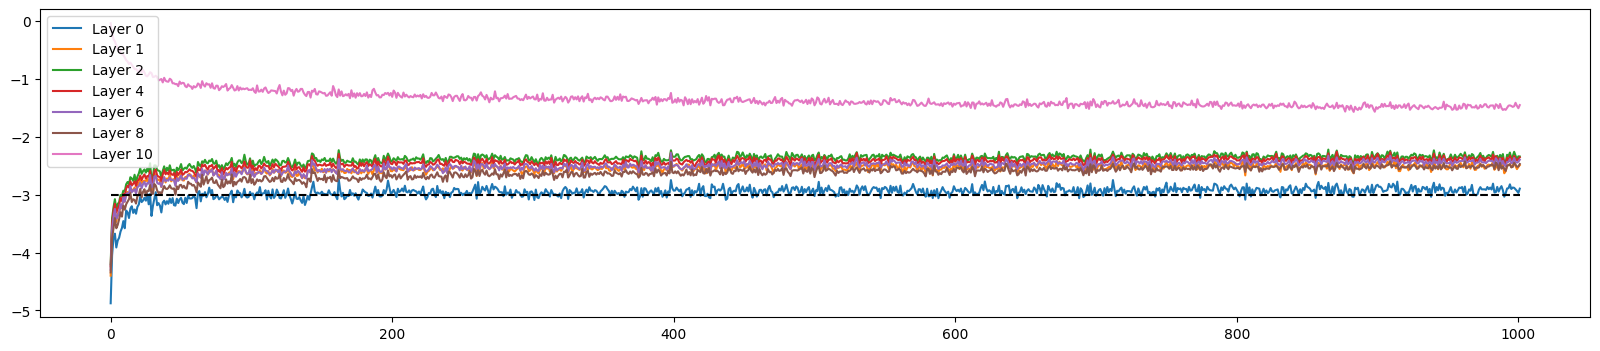

In [ ]:
# Update to data ratio
# We're calculating the ratio of lr * grad.std() / data.std()
# With this ratio we are seeing how much the update affects the data
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(ud))])
        legends.append(f"Layer {i}")
plt.plot([-3]*len(update_to_data_ratio), "k--")
plt.legend(legends);

In [207]:
@torch.no_grad()  # avoids gradient bookeeping for backward pass
def split_loss(split_name: str):
    x, y = {
        "train": (train_xs, train_ys),
        "dev": (dev_xs, dev_ys),
        "test": (test_xs, test_ys)
    }[split_name]
    for l in model.layers:
        if isinstance(l, BatchNorm1d):
            l.training = False
    logits = model(x)
    loss = F.cross_entropy(logits, y).item()
    print(f"{split_name=}, {loss=}")

split_loss("train")
split_loss("dev")

split_name='train', loss=2.375892400741577
split_name='dev', loss=2.3790841102600098
